In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qmmc.structure2 import *

## Generate data from a model

In [3]:
# Hyperpriors
mu_0, sigma_0 = Value(0), Value(.5)
scale_0, shape_0 = Value(3), Value(5)
n = Value(500)

# Priors and variables
mu_V_real = Normal(mu_0, sigma_0, name='mu_V_real')
sigma_V_real = InvGamma(scale_0, shape_0, name='sigma_V_real')
V_real = Normal(mu_V_real, sigma_V_real, size=n.value, name='V_real')

mu_WY_real = Normal(mu_0, sigma_0, name='mu_WY_real')
sigma_WY_real = InvGamma(scale_0, shape_0, name='sigma_WY_real')
Y_real = Normal(mu_WY_real, sigma_WY_real, size=n.value, name='Y_real')
W_real = Normal(mu_WY_real, sigma_WY_real, size=n.value, name='W_real')


@Function
def S_real(Y=Y_real, V=V_real, W=W_real):
    d = np.zeros(Y.shape[0], dtype=int)
    d[V > np.minimum(Y, W)] = 1
    d[Y < W] *= 2
    return d

p = Value(0.01)
I_real = BernoulliFlip(p, S_real)

In [4]:
print mu_V_real.value, sigma_V_real.value
print mu_WY_real.value, sigma_WY_real.value
print S_real.value[:50]
print I_real.value[:50]

0.22574341787 1.11314770552
0.178713272981 1.44204091175
[2 0 1 1 2 0 1 1 1 1 1 0 2 0 2 0 2 0 2 1 2 2 1 0 1 2 2 2 1 2 2 0 0 0 2 2 2
 2 1 1 0 2 1 1 2 2 2 0 2 2]
[2 0 1 1 2 0 1 1 1 1 1 0 2 0 2 0 2 0 2 1 2 2 1 0 1 2 2 2 1 2 2 0 0 0 2 2 2
 2 1 1 0 2 1 1 2 2 2 0 2 2]


## Estimate model parameters from data

In [5]:
# Priors and variables
mu_V = Normal(mu_0, sigma_0, value=mu_V_real.value + 1, name='mu_V')
sigma_V = InvGamma(scale_0, shape_0, value=sigma_V_real.value + 1, name='sigma_V')
V = Normal(mu_V, sigma_V, size=n.value, value=V_real.value + 1, name='V')

mu_Y = Normal(mu_0, sigma_0, value=mu_WY_real.value + 1, name='mu_Y')
sigma_Y = InvGamma(scale_0, shape_0, value=sigma_WY_real.value + 1, name='sigma_Y')
Y = Normal(mu_Y, sigma_Y, value=Y_real.value, observed=True, name='Y')

# mu_W = Normal(mu_0, sigma_0, value=mu_WY_real.value + 1, name='mu_W')
# sigma_W = InvGamma(scale_0, shape_0, value=sigma_WY_real.value, observed=True, name='sigma_W')
W = Normal(mu_Y, sigma_Y, size=n.value, name='W')

@Function
def S(Y=Y, V=V, W=W):
    d = np.zeros(Y.shape[0], dtype=int)
    d[V > np.minimum(Y, W)] = 1
    d[Y < W] *= 2
    return d

p = Value(0.01)
I = BernoulliFlip(p, S, value=I_real.value, observed=True, name='I')

In [6]:
model = Model([mu_V, sigma_V, V, W, mu_Y, sigma_Y, Y, S, I])

In [7]:
f = 30
print S.value[:f]
print I_real.value[:f]

[2 0 0 2 1 1 0 2 2 2 0 1 2 2 2 1 1 1 2 1 2 2 2 0 1 2 2 2 2 2]
[2 0 1 1 2 0 1 1 1 1 1 0 2 0 2 0 2 0 2 1 2 2 1 0 1 2 2 2 1 2]


In [8]:
model.estimate(100000)

In [9]:
f = 30
print S.value[:f]
print I_real.value[:f]

[2 0 0 2 1 1 0 2 2 2 0 1 2 2 2 1 1 1 2 1 2 2 2 0 1 2 2 2 2 2]
[2 0 1 1 2 0 1 1 1 1 1 0 2 0 2 0 2 0 2 1 2 2 1 0 1 2 2 2 1 2]


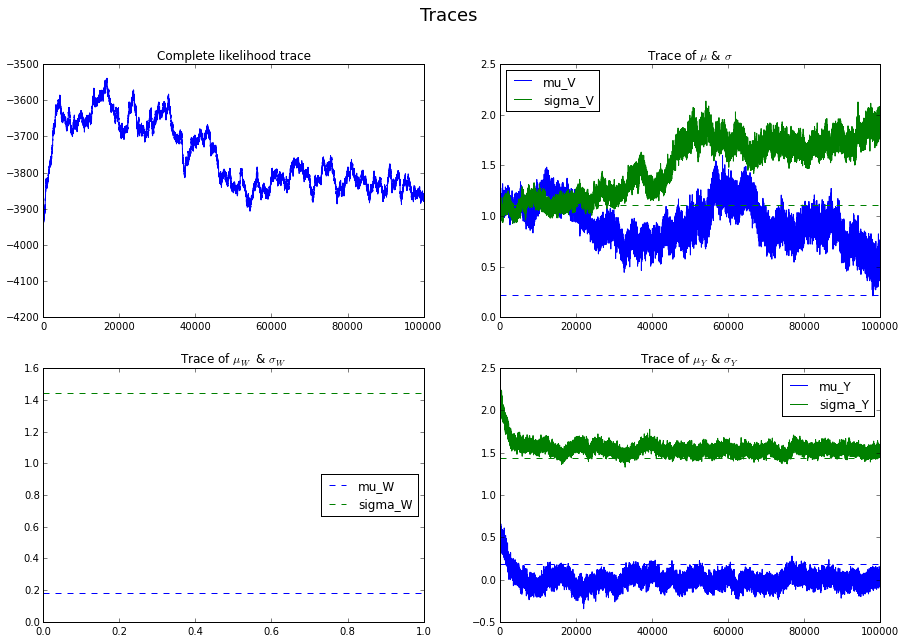

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.logp_history)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
plt.plot(model.samplers['mu_V'].get_history())
plt.plot(model.samplers['sigma_V'].get_history())
plt.axhline(mu_V_real.value, linestyle='--')
plt.axhline(sigma_V_real.value, color='g', linestyle='--')
plt.legend(["mu_V", "sigma_V"], loc='best')
plt.title(r"Trace of $\mu$ & $\sigma$")

plt.subplot(2, 2, 3)
# plt.plot(model.samplers['mu_W'].get_history())
# plt.plot(model.samplers['sigma_W'].get_history())
plt.axhline(mu_WY_real.value, linestyle='--')
plt.axhline(sigma_WY_real.value, color='g', linestyle='--')
plt.legend(["mu_W", "sigma_W"], loc='best')
plt.title(r"Trace of $\mu_W$ & $\sigma_W$")

plt.subplot(2, 2, 4)
plt.plot(model.samplers['mu_Y'].get_history())
plt.plot(model.samplers['sigma_Y'].get_history())
plt.axhline(mu_WY_real.value, linestyle='--')
plt.axhline(sigma_WY_real.value, color='g', linestyle='--')
plt.legend(["mu_Y", "sigma_Y"], loc='best')
plt.title(r"Trace of $\mu_Y$ & $\sigma_Y$")

plt.suptitle(r"Traces", size=18)
plt.show()

In [11]:
model.samplers

{'V': <qmmc.structure2.NormalMHSampler at 0x107f06150>,
 'W': <qmmc.structure2.NormalMHSampler at 0x107f06510>,
 'mu_V': <qmmc.structure2.NormalMHSampler at 0x107f06290>,
 'mu_Y': <qmmc.structure2.NormalMHSampler at 0x107f06910>,
 'sigma_V': <qmmc.structure2.NormalMHSampler at 0x107f06310>,
 'sigma_Y': <qmmc.structure2.NormalMHSampler at 0x107f06a10>}

In [12]:
model.samplers["mu_V"].dependent

{V}

[2 2 2 2 2 1 2 1 2 0 1 0 1 1 1 0 1 2 2 1 0 2 2 1 2 2 2 2 1 2]
[1 2 1 2 0 1 2 0 2 0 0 0 2 0 0 0 1 1 2 2 0 1 0 0 2 1 1 2 1 1]
